# Notebook 3 : Emerging topic detection

Began 30 April 2020 by Amaury de Barbuat from ECL

Updated by William Riou from ENSTA PARIS

# 0- Intro

This notebook follows the topic analysis through time notebook which provides data about topics, keywords, and their respective strengths. Here we try to exploit these data to implement an emerging topic detection tool.

This notebook has 3 parts :

- to define a metric to provide an unique label to each topic through time;

- to draw the evolution of a topic's strength through time;

- to detect anomalies in a topic's evolution to qualify it as emerging.

The hardest part is the first one. Indeed the same topic can be described by closed but different words. As a result different keywords may appear to describe it. Two possible issues for a same topic : either it appears two times in the same window, either it appears differently in consecutive windows. Defining a metric to give topics an unique label will allow us to track them correctly through time.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

## 1- Fixing label issues

### 11- Giving a synthetic label

In [10]:
def process_keywords(keywords_row, weights_row):

# k0 = hold short;short rwy;rwy hold;taxi rwy;gnd ctl;short runway;short lines;cross rwy
# k1 = ['hold', 'short', 'short', 'rwy', 'rwy', 'hold', 'rwy', 'rwy', 'taxi', 'rwy', 'short', 'lines', 'short', 'runway', 'crossed', 'hold']
# k2 = ['hold', 'short', 'short', 'rwy', 'rwy', 'hold', 'rwy', 'rwy', 'taxi', 'rwy', 'short', 'lines', 'short', 'runway', 'crossed', 'hold']
# k3 = ['hold', 'short', 'rwy', 'taxi', 'lines', 'runway', 'crossed']
# w0 = 0.0352;0.0328;0.5452;0.0416;0.0713;0.2182;0.0272;0.0286
# w1 = ['0.0373', '0.0373', '0.0686', '0.0686', '0.2007', '0.2007', '0.5596', '0.5596', '0.035', '0.035', '0.0411', '0.0411', '0.0225', '0.0225', '0.0351', '0.0351']
# w2 = [0.2731, 0.16949999999999998, 1.4235, 0.035, 0.0411, 0.0225, 0.0351]

# k0 : input words
# k1 : words splitted in a list
# k2 : same but stemmed words
# k3 : select one occurence of the same words that may appears multiple times e.g. 'short'
# w0 : respective weights for each pair of words
# w1 : weights splitted
# w2 : weight selection corresponding to k3 final list of words

    k0=keywords_row.split(';')
    n=len(k0)
    for i in range (n):
        k0[i]=k0[i].split(' ')
    k1=[]
    for i in range(n):
        k1.append(k0[i][0])
        k1.append(k0[i][1])

    #from nltk.stem.porter import PorterStemmer
    #porter = PorterStemmer()
    #k2 = [porter.stem(word) for word in k1]
    k2=k1
    
    k3=[]
    for i in k2 : 
        if i not in k3:
            k3.append(i)
    
    w0=weights_row.split(';')
    w1 = []
    for i in w0:
        w1.extend([i, i])

    w2=[]
    for e in k3:
        W=0
        for j in range (len(k2)):
            if k2[j]==e:
                W+=float(w1[j])
        w2.append(W)

    return k3, w2

In [11]:
def select_keywords(k, w, num_words):

# keeping the n biggest weights and words associated

    if len(k)>num_words:
        label=[]
        for i in range (num_words):
            a=w.index(max(w))
            label.append(k[a])
            w[a]=0
        return label
    
    else :
        return k

In [12]:
def topic_labelling(keywords_filename, weights_filename, num_words, output_filename):

# running process_keywords() and select_keywords() over the dataframe extracted from Nucleus analysis
    
    import pandas as pd
    
    # load columns of keywords and their weights
    keywords=pd.read_csv(keywords_filename, sep=';')
    weights=pd.read_csv(weights_filename, sep=';')
    
    # create an empty dataframe with same dimensions
    n=len(weights)
    periods=list(weights.head())[1:]
    topics = pd.DataFrame({}, columns = periods, index = [k for k in range (1, n+1)])
    
    for period in periods :
        E=[]
        for i in range (n):
            k, w = process_keywords(keywords[period][i], weights[period][i])
            label=select_keywords(k, w, num_words)
            s=' '
            E.append(s.join(label))
        topics[period]=E
    
    topics.to_csv(output_filename, sep=';', header=True, index=True)

In [13]:
topic_labelling('Keywords.csv', 'Weights.csv', 8, 'topics.csv')

FileNotFoundError: [Errno 2] File keywords.csv does not exist: 'keywords.csv'

### 12- Fixing intra-column issues

In [6]:
def intra_col(topics_filename, strength_filename, topics_output, strength_output):
    import pandas as pd
    topics=pd.read_csv(topics_filename, sep=';')
    strength=pd.read_csv(strength_filename, sep=';')

    n=len(topics)
    periods=list(topics.head())[1:]
    new_topics=pd.DataFrame({}, columns = periods, index = [k for k in range (1, n+1)])
    new_strength=pd.DataFrame({}, columns = periods, index = [k for k in range (1, n+1)])
    
    for period in periods :
        
        L=list(topics[period]) # L=['hold short apch', 'visual land clear', ...]
        M=list(strength[period]) # M=['0.2', '0.35', ...]
        T=[]
        S=[]
        s=' '
        for l in L: # l='hold short apch'
            m=l.split() # m=['hold', 'short', 'apch']
            c=0
            for j in range(len(T)):
                sim_score=0
                U=[]
                for e in m:
                    if e in T[j]:
                        sim_score+=1
                    #else:
                        #U.append(e)
                if len(T[j])<len(m):
                    sim_score=sim_score/(len(T[j]))
                else:
                    sim_score=sim_score/len(m)
                if sim_score >= 0.4:
                    S[j]+=M[L.index(l)]
                    #T[j]+=s.join(U)
                    c=c+1
                    
            if c==0:
                T.append(s.join(m))
                S.append(M[L.index(l)])
        
        
        p = len(L)-len(T)
        if p>0:
            T=T+[None]*p
            S=S+[0]*p

        new_topics[period]=T
        new_strength[period]=S

    new_topics.to_csv(topics_output, sep=';', header=True, index=True)
    new_strength.to_csv(strength_output, sep=';', header=True, index=True)

In [7]:
intra_col('topics.csv', 'strength.csv','temp_topics.csv', 'temp_strength.csv')

FileNotFoundError: [Errno 2] File topics.csv does not exist: 'topics.csv'

### 13- Fixing inter-column issues

In [5]:
def sim_score(L,M):
    S=0
    for e in L:
        if e in M:
            S=S+1
    if S>0:
        if len(L)<len(M):
            S=S/len(L)
        else:
            S=S/len(M)
    return S

In [6]:
def is_in_df(value, dataframe):
    c=0
    for col in dataframe.columns:
        if value in list(dataframe[col]):
            c=c+1
            break
    if c>0:
        return True
    else:
        return False

In [7]:
def inter_col(temp_topics, temp_strength, final_topics, final_strength):
    
    import pandas as pd

    temp_topics=pd.read_csv(tem_topics, sep=';')
    temp_strength=pd.read_csv(temp_strength, sep=';')

    periods=list(temp_topics.head())[1:]

    final_topics=pd.DataFrame({}, columns = periods)
    final_strength=pd.DataFrame({}, columns = periods)

    m=len(periods)
    n=len(temp_topics)
    s=' '

    for period in periods:

        new_periods=periods.copy()
        new_periods.remove(period)
        indp=periods.index(period)

        for t in temp_topics[period]:

            if type(t) == str :

                if is_in_df(t, final_topics) == True:
                    continue

                indt=list(temp_topics[period]).index(t)
                t=t.split() # t=['hold', 'short']

                T=[]
                S=[]
                c=0
                d=0

                for p in new_periods:

                    if c==indp:
                        S.append(temp_strength[period][indt])
                        T.append(s.join(t))
                        d=d+1

                    b=False

                    for t2 in temp_topics[p]:

                        if type(t2) == str:

                            if is_in_df(t2, final_topics) == True:
                                continue

                            indt2=list(temp_topics[p]).index(t2)
                            t2=t2.split()

                            if sim_score(t,t2) >= 0.5:
                                T.append(s.join(t2))
                                S.append(temp_strength[p][indt2])
                                b=True
                                break

                    if b==False :
                        T.append(None)
                        S.append(0)

                    c=c+1

                if d==0:
                    S.append(temp_strength[period][indt])
                    T.append(s.join(t))


                dft=pd.DataFrame([T], columns=periods)
                dfs=pd.DataFrame([S], columns=periods)
                final_topics=final_topics.append(dft, ignore_index = True)
                final_strength=final_strength.append(dfs, ignore_index = True)

    final_topics.to_csv(final_topics, sep=';', header=True, index=True)
    final_strength.to_csv(final_strength, sep=';', header=True, index=True)

In [11]:
inter_col('temp_topics.csv', 'temp_strength.csv', 'final_topics.csv', 'final_strength.csv')

NameError: name 'tem_topics' is not defined

## 2- Detecting emerging topics

### 21- Plotting a specific topic

In [8]:
def get_words(data_filename, topic_number):
    import pandas as pd
    data=pd.read_csv(data_filename, sep=';')
    X=list(data.loc[topic_number])[1:]
    print(X)

In [13]:
get_words('final_topics.csv', 10)

['eicas message edge leading trailing flap wing slat', nan, 'light illuminated edge eicas message trailing leading flap', 'edge light illuminated eicas message trailing leading flap', 'eicas message edge leading trailing flap wing slat', 'edge trailing leading flap devices slat transit light', 'eicas message edge leading light caution illuminated slat', 'edge flap leading trailing engine start slat devices', nan, 'leading edge trailing flap flaps slat wing devices', 'leading edge trailing flap flaps slat devices wing', nan, 'edge flaps leading eicas slat message engine start', nan, 'message illuminated engine start leading edge eicas appeared', nan, nan, 'edge slat leading trailing thrust reverser flap flaps', 'leading edge trailing flap flaps slat devices wing', 'eicas message maintenance manual light leading edge assigned', 'message appeared disagree eicas engine leading edge flap', 'leading edge trailing slat flap devices flaps wing', nan, 'leading edge trailing slat devices wing fl

In [14]:
def plot_topic(data_filename, topic_number):
    
    import pandas as pd
    data=pd.read_csv(data_filename, sep=';')
    X=list(data.loc[topic_number])[1:]

    import matplotlib.pyplot as plt
    plt.plot(X)
    plt.ylabel("Strength (/1)")
    plt.xlabel("Periods (2 months)")
    plt.show()

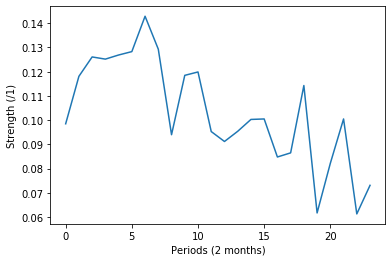

In [15]:
plot_topic('final_strength.csv', 1)

### 22- Getting the interval of variations

In [16]:
def plot_ampl(filename):
    
    import pandas as pd
    data=pd.read_csv(filename, sep=';')
    n=len(data)

    Y=[]
    for i in range (n):
        y=list(data.loc[i])[1:]
        y2=[]
        for e in y:
            if e != 0:
                y2.append(e)
        if len(y2)>=2:
            mean=0
            S=0
            for e in y2:
                mean=mean+e
                S=S+1
            mean=mean/S
            M=max(y2)
            m=min(y2)
            var=(M-m)/mean
            Y.append(var)
    
    Z=Y.copy()
    Z.sort(reverse=True)
    print('Smallest amplitude :', Z[-1])
    print('Biggest amplitude :', Z[0])
    
    L=[]
    for i in range(len(Y)):
        a=Y.index(Z[i])
        while a in L:
            a=Y.index(Z[i],a+1)
        L.append(a)
        
    #print('Biggest amplitudes :', Z[:3])
    #print('Topics corresponding :', L[:3])
    print(len(L))

    import matplotlib.pyplot as plt
    plt.plot(Z)
    plt.ylabel("Amplitude (%)")
    plt.xlabel("Topic")
    plt.show()

Smallest amplitude : 0.005698005698005663
Biggest amplitude : 1.7871093749999998
196


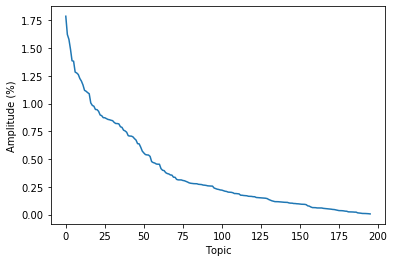

In [17]:
plot_ampl('final_strength.csv')

### c) detection tool

In [18]:
def detect_move(data_filename, topic_number, criteria):
    
    import pandas as pd
    data=pd.read_csv(data_filename, sep=';')
    X=list(data.loc[topic_number])[1:]
    
    X2=[]
    for e in X:
        if e!=0:
            X2.append(e)
    
    if len(X2)>=5 :
        for i in range (1, len(X)):
            delta=X[i]-X[i-1]
            if delta>criteria:
                print('emerging at period ', i)
            if delta<-criteria:
                print('disapperance at period ', i)
    
    else :
        print('Topic has less than 5 occurences in the timeline')

In [19]:
detect_move('final_strength.csv', 101, 0.01)

emerging at period  3
disapperance at period  8
emerging at period  9
disapperance at period  11
emerging at period  12
disapperance at period  13
emerging at period  15
emerging at period  18
disapperance at period  19


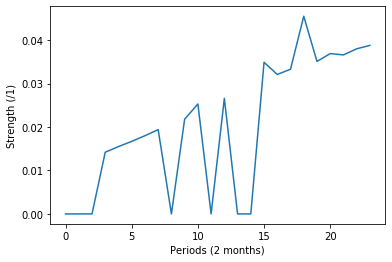

In [20]:
plot_topic('final_strength.csv', 101)